При помощи запросов вида:
```lang-sql
select id, title, body, CreationDate, tags from posts
where creationdate between date1 and date2;
```

к https://data.stackexchange.com/stackoverflow/query/new получим несколько csv-файлов с информацией о постах за последние 6 месяцев (делила на несколько запросов, так как на сайте есть ограничение на максимальное количество возвращаемых строк в 50000). После этого объединим все файлы в один общий (last_half_year_posts.csv)

In [1]:
import pandas as pd

posts_data = pd.read_csv('last_half_year_posts.csv')
posts_data.head(10)

,id,title,body,CreationDate,tags
0,69293090,Unable to send OTP code for Xamarin Android Fi...,<p>I am creating a cross platform mobile app (...,2021-09-23 01:49:24,<firebase><firebase-authentication><xamarin.an...
1,69292462,React component modal is open at load and neve...,<p>I'm experimenting a modal that opens when I...,2021-09-23 00:00:07,<javascript><reactjs>
2,69292463,NaN,<p>im super late but trying using &quot;===&qu...,2021-09-23 00:00:10,NaN
3,69292464,NaN,<p>You can solve this by Re-aggregating the Da...,2021-09-23 00:00:23,NaN
4,69293091,Any way to open a modal dialog without explici...,"<p>I have been using react-modal recently, and...",2021-09-23 01:49:31,<reactjs><react-modal>
5,69293093,NaN,<pre><code>storageclass.storage.k8s.io &quot;e...,2021-09-23 01:50:35,NaN
6,69292466,Sort two different ranges based on one column ...,"<p>In a task I've been working on, I need to s...",2021-09-23 00:00:41,<excel><vba>
7,69293094,NaN,<p>You cannot redeclare a variable previously ...,2021-09-23 01:50:49,NaN
8,69293096,NaN,<p>The console environment has a number of odd...,2021-09-23 01:51:09,NaN
9,69292467,getting and passing object to node js render m...,<p>I am playing around with the alpha vantage ...,2021-09-23 00:00:42,<node.js><express>


In [2]:
posts_data.shape

(1815296, 5)

In [3]:
posts_data = posts_data.dropna(subset=['body'])
posts_data.shape

(1814599, 5)

При помощи нескольких запросов вида (добавляя ограничения на значение count):

```lang-sql
select id, TagName, count from tags
order by count desc;
```

получим csv-файл со всеми тэгами, встречавшимися в постах на StackOverFlow. Затем почистим его: удалим слова, которые могут часто встречаться в коде и не дают понимания о том, какие технологии сейчас обсуждаются больше всего (например, include, main, return, char, where, was и т.д). Полученный файл назовём clean_tags.csv

In [4]:
tags_data = pd.read_csv('clean_tags.csv')
tags_data.head(10)

,id,TagName,count
0,3,javascript,2334428
1,16,python,1888123
2,17,java,1826880
3,9,c#,1521772
4,5,php,1427966
5,1386,android,1364233
6,2,html,1113566
7,820,jquery,1022905
8,10,c++,754278
9,4,css,748298


In [5]:
tags_data.shape

(62969, 3)

In [6]:
tags_set = set(tags_data['TagName'])

In [7]:
tags_frequency = dict.fromkeys(tags_set, 0)

In [8]:
import re

clean_pattern = re.compile('<.*?>') 

def clean_html(raw_html):
    clean_text = re.sub(clean_pattern, '', raw_html)
    return clean_text

Чтобы узнать, какие технологии наиболее часто обсуждаются на StackOverFlow в последние полгода, выделим в постах "ключевые слова" (ключевыми будем считать слова, которые хотя бы однажды были тэгом). Посчитаем, во скольких свежих (последние 6 месяцев) постах встретился каждый из тэгов:

In [9]:
from tqdm.notebook import tqdm

for idx, row in tqdm(posts_data.iterrows()):
    curr_text = row['body']
    clean_text = clean_html(curr_text)
    words = clean_text.split()
    tags_in_text = []
    for word in words:
        if word in tags_set:
            tags_in_text.append(word)
    real_tags = row['tags'][1:-1].split("><") if isinstance(row['tags'], str) else []
    all_tags = set(tags_in_text + real_tags)
    for tag in all_tags:
        if tag in tags_set:
            tags_frequency[tag] += 1

0it [00:00, ?it/s]

In [10]:
tags_freq = pd.DataFrame.from_dict({
    'tags': tags_frequency.keys(),
    'frequency': tags_frequency.values(),
})
tags_freq = tags_freq.loc[(tags_freq['frequency'] > 0)]
tags_freq = tags_freq.sort_values(by=['frequency'], ascending=False, ignore_index=True)

Посмотрим, какие тэги встречались в постах чаще всего:

In [11]:
tags_freq.head(10)

,tags,frequency
0,python,157708
1,javascript,104142
2,go,58580
3,java,54511
4,html,52352
5,script,50293
6,reactjs,48510
7,database,47074
8,r,39114
9,pandas,38311


# Визуализация

Построим столбчатую диаграмму с частотами самых популярных технологий за последние полгода:

Text(0.5, 1.0, 'TOP 25 technologies which occurred in posts on StackOverFlow')

<Figure size 1800x1080 with 0 Axes>

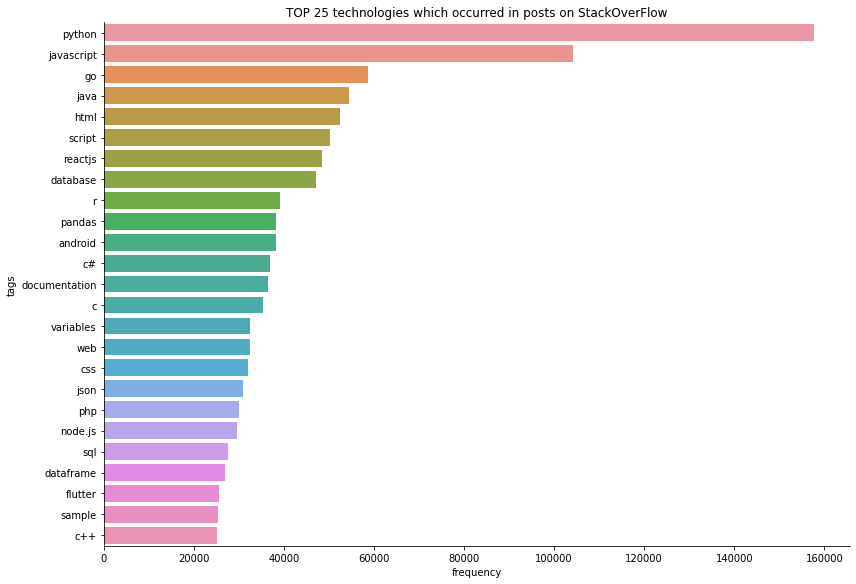

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

tags_top25 = tags_freq[:25]
plt.figure(figsize=(25,15))
sns.catplot(x = 'frequency' , y='tags', kind="bar", data=tags_top25, height=8, aspect=1.5)
plt.title('TOP 25 technologies which occurred in posts on StackOverFlow')

А также построим облако слов из топ-100 популярных в постах технологий:

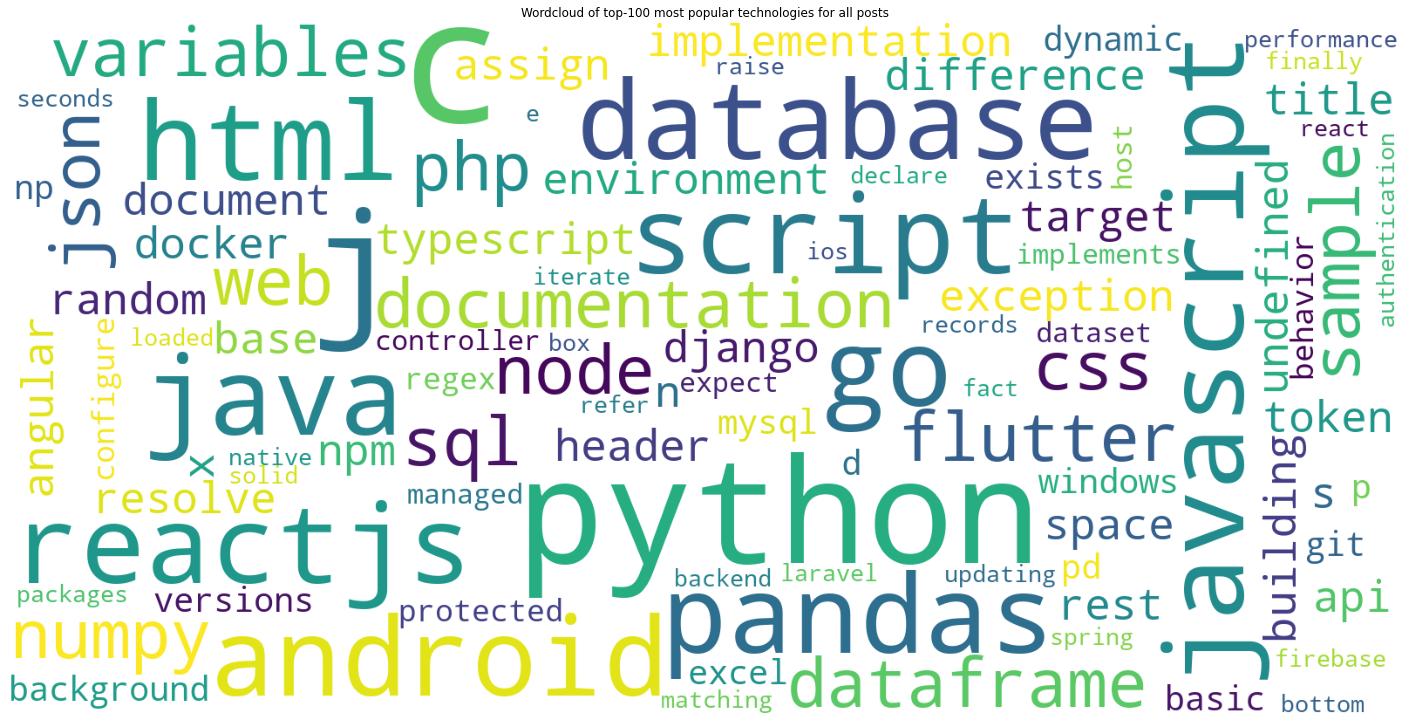

In [13]:
from wordcloud import WordCloud

text = " ".join(tags_freq['tags'][:100])
wordcloud = WordCloud(
    width=1600, height=800, max_font_size=200, background_color="white", collocations=True,
).generate(text)

plt.figure(figsize=(25,15))
plt.imshow(wordcloud)
plt.title('Wordcloud of top-100 most popular technologies for all posts')
plt.axis("off")
plt.show()